micro model is a model trained on a small data set containing only specific fighter & an opponent of an upcoming fight,
it should show trends that belong to specific fighters or fighting styles

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
import datetime as dt
import numpy as np
from bokeh.plotting import show
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import tree 

import seaborn as sns
sns.set_style("ticks")
sns.set_context("notebook", rc={"lines.linewidth": 2})

import statistics as stat
import random
import matplotlib.pyplot as plt
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

pd.set_option("display.max_columns", None)

input parameters

In [16]:
red_fighter = 'Sean Strickland'
blue_fighter = 'Nassourdine Imavov'

preparing data frame

In [22]:
loc = 'data/'
file = 'ufc_data_features.csv'
df = pd.read_csv(loc+file)
df = df[df.columns[1:]]
print('Data Frame loaded: '+str(df.shape))
df.tail(1)

Data Frame loaded: (6793, 22)


,result,fighter,opponent,date,weight class,method,kd_dif,str_dif,td_dif,sub_dif,td avg._dif,td acc._dif,td def._dif,sub. avg._dif,slpm_dif,str. acc._dif,sapm_dif,str. def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif
6792,lose,Joshua Burkman,Drew Dober,2017-07-29,Lightweight,KO/TKO:Punch,-1.358127,-0.147449,0.001742,-0.009118,1.009951,0.674667,0.620796,0.182521,-1.112197,0.253815,-0.6283,0.002428,-1.188484,-0.122326,-0.014125,2.153078


In [23]:
df = (df[(df.fighter==red_fighter)|(df.opponent==blue_fighter)|(df.fighter==blue_fighter)|(df.opponent==red_fighter)]).reset_index(drop=True)
df = df.drop(columns=['date','weight class','method'])
df.tail(3)

,result,fighter,opponent,kd_dif,str_dif,td_dif,sub_dif,td avg._dif,td acc._dif,td def._dif,sub. avg._dif,slpm_dif,str. acc._dif,sapm_dif,str. def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif
19,win,Nassourdine Imavov,Ian Heinisch,-0.005772,0.567212,0.396182,-0.009118,-0.019691,0.219684,0.587298,1.613356,0.530882,0.334959,-0.336185,0.254871,-0.136721,0.005604,-0.014125,0.000317
20,win,Kamaru Usman,Sean Strickland,1.346582,2.372671,0.790623,-0.009118,1.060041,-0.445292,0.419809,-0.199035,-0.614866,1.065261,-0.883901,-0.670753,0.279075,0.440565,0.557095,0.000317
21,win,Sean Strickland,Tom Breese,-0.005772,0.416757,0.001742,-0.009118,0.653750,2.144614,0.520303,-0.771369,1.393341,-0.801066,0.728817,0.423166,-1.188484,-0.506115,-0.585345,0.000317


#### Features analysis

<AxesSubplot:xlabel='win_strk_dif', ylabel='Count'>

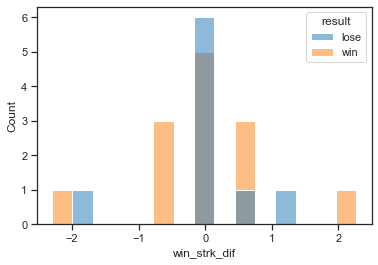

In [58]:
features = df.columns[3:]

rows = 1
cols = len(features)-2
#fig, axs = plt.subplots(rows,cols,figsize = (45,5))

#sns.scatterplot(data=df, x='win_strk_dif', y='str_dif',hue='result')
sns.histplot(data=df,x='win_strk_dif',hue='result',)

In [35]:
df.columns

Index(['result', 'fighter', 'opponent', 'kd_dif', 'str_dif', 'td_dif',
       'sub_dif', 'td avg._dif', 'td acc._dif', 'td def._dif', 'sub. avg._dif',
       'slpm_dif', 'str. acc._dif', 'sapm_dif', 'str. def_dif',
       'stance_win_ratio', 'win_perc_dif', 'win_strk_dif', 'lose_strk_dif'],
      dtype='object')

#### set new upcoming fight:

In [25]:
def set_new_fight(fighter, opponent, data):
    
    row = {'date': get_current_date(),
           'result': None,
           'fighter': fighter,
           'opponent': opponent,
           'win_perc_dif': get_win_perc(fighter=fighter, data=data) - get_win_perc(fighter=opponent, data=data),
           'win_strk_dif': get_win_streak(fighter=fighter, data=data) - get_win_streak(fighter=opponent, data=data),
           'lose_strk_dif': get_lose_streak(fighter=fighter, data=data) - get_lose_streak(fighter=opponent, data=data),
           'td avg._dif': get_td_avg(fighter=fighter, data=stats) - get_td_avg(fighter=opponent, data=stats),
           'sub. avg._dif': get_sub_avg(fighter=fighter, data=stats) - get_sub_avg(fighter=opponent, data=stats),
           'sapm_dif': get_sapm(fighter=fighter, data=stats) - get_sapm(fighter=opponent, data=stats),
           'slpm_dif': get_slpm(fighter=fighter, data=stats) - get_slpm(fighter=opponent, data=stats),
           'kd_dif':None,
           'str_dif':None,
           'td_dif':None,
           'sub_dif':None,
          }
    return pd.DataFrame(row, index=[0])

In [26]:
def get_current_date():
    from datetime import date
    import pandas as pd
    return pd.to_datetime(date.today())

def get_win_perc(fighter, data=df):
    '''return current career winning %'''
    date = get_current_date()
    wins = len(data[(data['fighter'] == fighter)&(data.date < date) & (data['result']=='win')]) + len(data[(data['opponent'] == fighter)&(data.date < date) & (data['result']=='lose')])
    losses = len(data[(data['fighter'] == fighter)&(data.date < date) & (data['result']=='lose')]) + len(data[(data['opponent'] == fighter)&(data.date < date) & (data['result']=='win')])
    
    if wins == 0:
        return 0
    return wins/(wins+losses)

def get_lose_streak(fighter, data=df):
    '''return current lose streak'''
    date = get_current_date()
    data = ((data[(data.date < date)&((data.fighter == fighter)|(data.opponent == fighter))]).sort_values(by=['date'], ascending=False)).reset_index(drop=True)
    
    count = 0
    for i in range(0,len(data)):
        
        result = data.loc[i,'result']
        f = data.loc[i,'fighter']
        o = data.loc[i,'opponent']
        
        if ((result == 'lose')&(f == fighter))|((result == 'win')&(o == fighter)):
            count += 1
        else:
            return count
    return count

def get_win_streak(fighter, data=df):
    '''return current win streak'''
    date = get_current_date()
    data = ((data[(data.date < date)&((data.fighter == fighter)|(data.opponent == fighter))]).sort_values(by=['date'], ascending=False)).reset_index(drop=True)
    
    count = 0
    for i in range(0,len(data)):
        
        result = data.loc[i,'result']
        f = data.loc[i,'fighter']
        o = data.loc[i,'opponent']
        
        if ((result == 'win')&(f == fighter))|((result == 'lose')&(o == fighter)):
            count += 1
        else:
            return count
    return count

def get_td_avg(fighter, data=stats):
    '''return current takedown average'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'td avg.']

def get_sub_avg(fighter, data=stats):
    '''return current submission average'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'sub. avg.']

def get_sapm(fighter, data=stats):
    '''return current strikes absorbed per minute'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'sapm']

def get_slpm(fighter, data=stats):
    '''return current strikes landed per minutes'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'slpm']